<h1> TRABAJO FINAL </h1>

<h2> preprocesamiento data set </h2>

In [ ]:
#aqui describir el data set 

In [1]:
#dependencias 
from pathlib import Path
from matplotlib import pyplot as plt 
import os
import cv2
import numpy as np
import math
import argparse
import glob



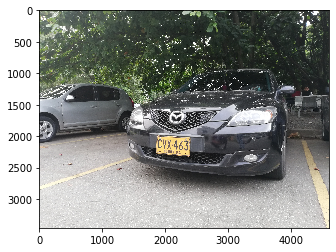

In [15]:
#obteniendo todas las imagenes en el directorio res
data_folder = Path("res")
arrayOfImages = glob.glob('./res/original/*.jpg')
path  = arrayOfImages[3]

#mostramos la primera imagen del directorio sin modificacion desde la adquisicion.
img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
plt.imshow(img)


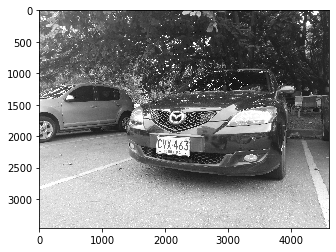

In [16]:
#Ahora mostramos la primera imagen en el canal value del hsv es decir en scala de grises solo conservando la instensidad
img2 = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2HSV)
plt.imshow(img2[:,:,2], cmap="gray")

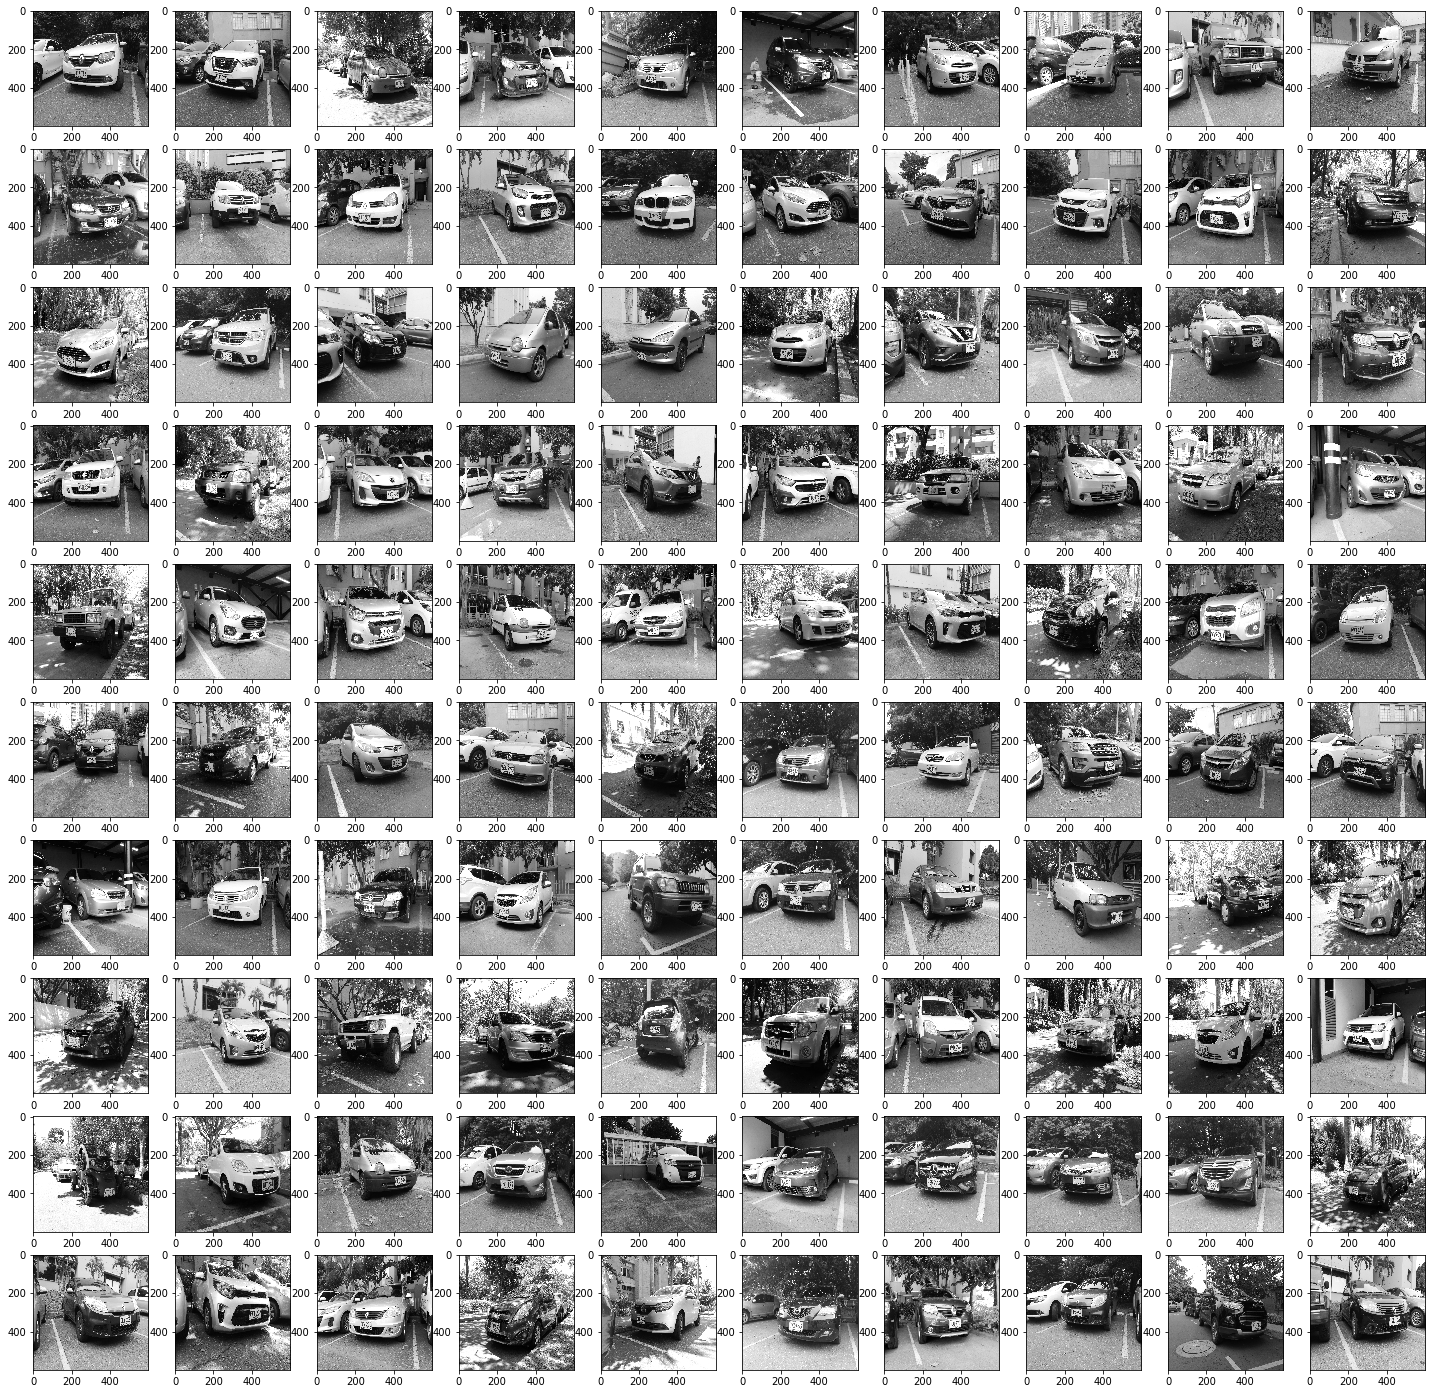

In [92]:
# Vamos a necisitar las imagenes en blanco y negro y reescaladas a un tamaño menor 
fig,arreglo_plots0 = plt.subplots(10,10, figsize=(25, 25))
arrayOfImages = ls(file_to_open)
for i in range (0,len(arrayOfImages)):
    path_origin  = folder_to_open / arrayOfImages[i]
    path_destin  = Path("res/resized/")
    img = cv2.cvtColor(cv2.imread(str(path_origin)), cv2.COLOR_BGR2HSV)
    #Redimensionamos las imagenes a un tamaño de 600*600 para el procesamiento de las imagenes
    #Solo consideramos el canal de intensidad para nuestros propositos
    arrayOfImages[i] = cv2.resize(img, (600, 600))[:,:,2]
    cv2.imwrite(os.path.join(path_destin, str(i) +  ".png") ,arrayOfImages[i]) 
    
i = 0
j = 0
k = 0
for i in range(0, 10):
    for j in range(0, 10):
        arreglo_plots0[i][j].imshow(arrayOfImages[k], cmap="gray")
        k += 1

In [2]:
#funciones para el prepocesamiento de las imagenes

# module level variables 
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 9

def preprocess(imgOriginal):
    imgGrayscale = extractValue(imgOriginal)

    imgMaxContrastGrayscale = maximizeContrast(imgGrayscale)

    height, width = imgGrayscale.shape

    imgBlurred = np.zeros((height, width, 1), np.uint8)

    imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)

    imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)

    return imgGrayscale, imgThresh

def extractValue(imgOriginal):
    height, width, numChannels = imgOriginal.shape

    imgHSV = np.zeros((height, width, 3), np.uint8)

    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)

    imgHue, imgSaturation, imgValue = cv2.split(imgHSV)

    return imgValue

def maximizeContrast(imgGrayscale):

    height, width = imgGrayscale.shape

    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)

    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat



In [3]:

def detectPlatesInScene(imgOriginalScene):
    listOfPossiblePlates = []                   # this will be the return value

    height, width, numChannels = imgOriginalScene.shape

    imgGrayscaleScene = np.zeros((height, width, 1), np.uint8)
    imgThreshScene = np.zeros((height, width, 1), np.uint8)
    imgContours = np.zeros((height, width, 3), np.uint8)

    cv2.destroyAllWindows()

    if showSteps == True: # show steps 
        cv2.imshow("0", imgOriginalScene)
    # end if # show steps 

    imgGrayscaleScene, imgThreshScene = preprocess(imgOriginalScene)         # preprocess to get grayscale and threshold images
    
    return imgGrayscaleScene , imgThreshScene

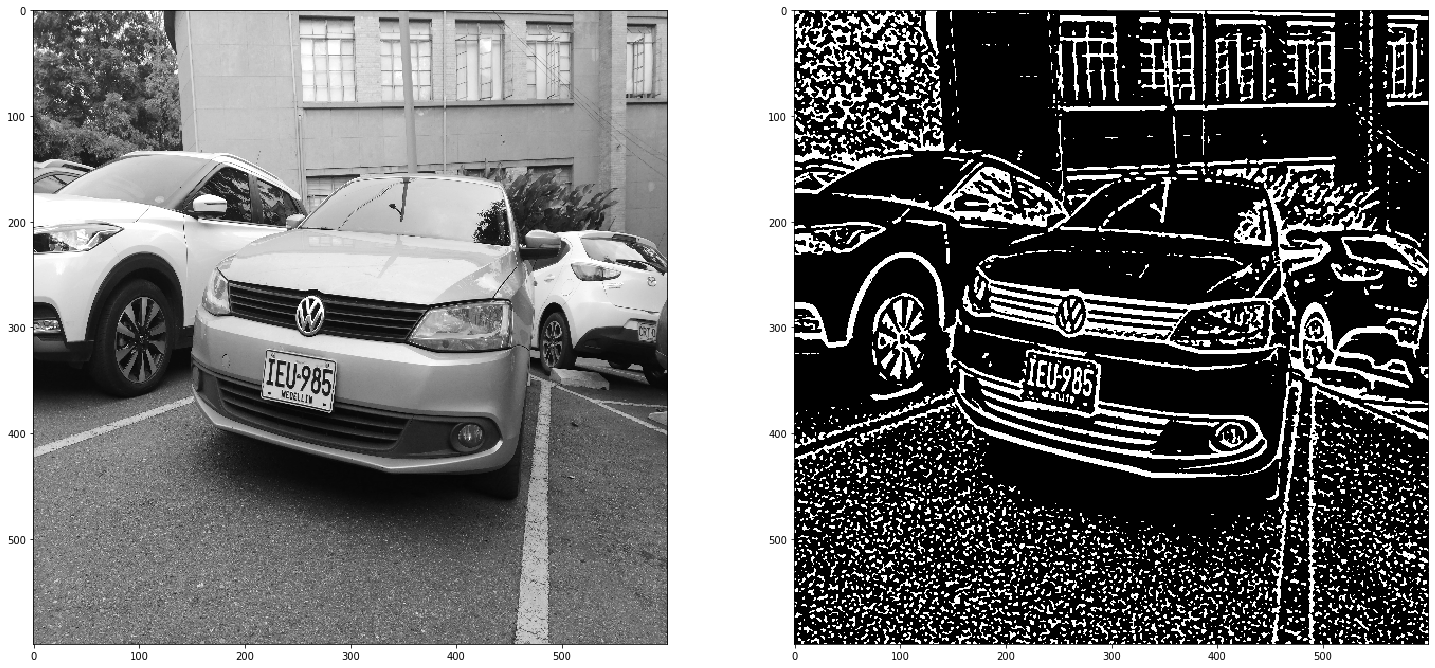

In [8]:
imgOriginalScene  = cv2.imread("./res/resized/53.png")               # open image
showSteps = False

if imgOriginalScene is None:                         # if image was not read successfully
    print("\nerror: image not read from file \n\n")  # print error message to std out
    os.system("pause")                                  # pause so user can see error message                                              # and exit program
    # end if

listOfPossiblePlates = detectPlatesInScene(imgOriginalScene)           # detect plates

fig,arreglo_plots0 = plt.subplots(1,2, figsize=(25, 25))
arreglo_plots0[0].imshow(listOfPossiblePlates[0], cmap="gray")
arreglo_plots0[1].imshow(listOfPossiblePlates[1], cmap="gray")

  



In [25]:
class PossiblePlate:
    def __init__(self):
        self.imgPlate = None
        self.imgGrayscale = None
        self.imgThresh = None
        self.rrLocationOfPlateInScene = None
        self.strChars = ""
        
class PossibleChar:

    # constructor #################################################################################
    def __init__(self, _contour):
        self.contour = _contour

        self.boundingRect = cv2.boundingRect(self.contour)

        [intX, intY, intWidth, intHeight] = self.boundingRect

        self.intBoundingRectX = intX
        self.intBoundingRectY = intY
        self.intBoundingRectWidth = intWidth
        self.intBoundingRectHeight = intHeight

        self.intBoundingRectArea = self.intBoundingRectWidth * self.intBoundingRectHeight

        self.intCenterX = (self.intBoundingRectX + self.intBoundingRectX + self.intBoundingRectWidth) / 2
        self.intCenterY = (self.intBoundingRectY + self.intBoundingRectY + self.intBoundingRectHeight) / 2

        self.fltDiagonalSize = math.sqrt((self.intBoundingRectWidth ** 2) + (self.intBoundingRectHeight ** 2))

        self.fltAspectRatio = float(self.intBoundingRectWidth) / float(self.intBoundingRectHeight)
    # end constructor
        

In [23]:
import dectecChar 
import 


In [24]:
# 

listOfPossiblePlates = detectCharsInPlates(listOfPossiblePlates)        # detect chars in plates

plt.imshow(imgOriginalScene)            # show scene image

if len(listOfPossiblePlates) == 0:                          # if no plates were found
    print("\nno license plates were detected\n")  # inform user no plates were found
else:                                                       # else
            # if we get in here list of possible plates has at leat one plate

            # sort the list of possible plates in DESCENDING order (most number of chars to least number of chars)
    listOfPossiblePlates.sort(key = lambda possiblePlate: len(possiblePlate.strChars), reverse = True)

            # suppose the plate with the most recognized chars (the first plate in sorted by string length descending order) is the actual plate
    licPlate = listOfPossiblePlates[0]

    plt.imshow( licPlate.imgPlate)           # show crop of plate and threshold of plate
    plt.imshow(licPlate.imgThresh)

    if len(licPlate.strChars) == 0:                     # if no chars were found in the plate
        print("\nno characters were detected\n\n")  # show message
        return                                          # and exit program
    # end if

    drawRedRectangleAroundPlate(imgOriginalScene, licPlate)             # draw red rectangle around plate

    print("\nlicense plate read from image = " + licPlate.strChars + "\n")  # write license plate text to std out
    print("----------------------------------------")

    writeLicensePlateCharsOnImage(imgOriginalScene, licPlate)           # write license plate text on the image

    plt.imshow("imgOriginalScene", imgOriginalScene)                # re-show scene image

    cv2.imwrite("imgOriginalScene.png", imgOriginalScene)           # write image out to file





AttributeError: 'numpy.ndarray' object has no attribute 'imgPlate'